This code is to calculate the window diagnostics for Wind and Precipitation from WRF output. And compare with the wrfdly output. This is to try and validate the output from WRF.

In [1]:
import xarray as xr
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
# Some inputs

# Paths
#data_path=Path("/g/data/w35/ccc561/WRF/wrfdly_test")
data_path=Path("/scratch/w35/ccc561/jenkins/workspace/WRF/WRF-CCRC/jenkins-tests/jan00-diagnostics")
wrfout_file="wrfout_d01_2000-01-24_12:00:00"
wrfdly_file="wrfdly_d01_2000-01-24_12:00:00"

# Time windows to calculate values on
Window_ave = pd.to_timedelta(["00:05:00","00:10:00","00:20:00","00:30:00","00:60:00"])

In [23]:
# Read in data for domain 1
out_d01=xr.open_dataset(data_path/wrfout_file)
dly_d01=xr.open_dataset(data_path/wrfdly_file)

# Decode the times and add as the XTIME coordinate to the dataset
times = [tt.item().decode() for tt in dly_d01["Times"]]
dly_time=xr.DataArray(pd.to_datetime(times,format="%Y-%m-%d_%H:%M:%S"),dims=["Time"],name="Time",coords={})
dly_d01=dly_d01.assign_coords({"Time":("Time",dly_time)})

In [28]:
# wrfout timestep. It should be the time step of the run
timestep = out_d01["XTIME"][1]-out_d01["XTIME"][0]
timestep = pd.to_timedelta(timestep.item())

# Select the first point only

<xarray.DataArray 'UV10MAX5' (Time: 8)>
array([13.064551, 13.064551, 13.064551, 12.312969, 12.312969, 12.312969,
       11.681395, 11.681395], dtype=float32)
Coordinates:
    XTIME    (Time) datetime64[ns] 2000-01-24T12:21:00 ... 2000-01-24T14:42:00
Dimensions without coordinates: Time
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  MAXIMUM 5 MIN. WIND SPEED
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME

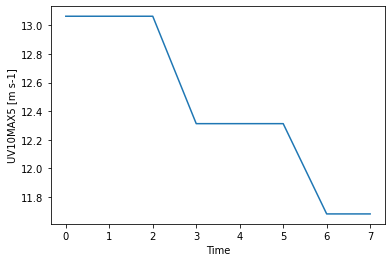

In [25]:
UV10MAX5=dly_d01["UV10MAX5"].isel(south_north=0,west_east=0,Time=slice(1,-1))
#UV10MAX5 = UV10MAX5.assign_coords({"XTIME":("Time",dly_time)})
UV10MAX5.plot()
UV10MAX5

In [26]:
TUV10MAX5 = dly_d01["TUV10MAX5"].isel(south_north=0,west_east=0,Time=slice(1,-1))
TUV10MAX5

<xarray.DataArray 'TUV10MAX5' (Time: 8)>
array([5., 5., 5., 2., 2., 2., 2., 2.], dtype=float32)
Coordinates:
    XTIME    (Time) datetime64[ns] 2000-01-24T12:21:00 ... 2000-01-24T14:42:00
Dimensions without coordinates: Time
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TIME OF MAXIMUM 5 MIN. WIND SPEED
    units:        minute
    stagger:      
    coordinates:  XLONG XLAT XTIME

## Calculate the wind speed and distance for the wind

In [55]:
U10_wrfout = out_d01["U10"][1:]
V10_wrfout = out_d01["V10"][1:]
Speed = xr.ufuncs.sqrt(U10_wrfout**2+V10_wrfout**2)
Speed.attrs["units"]=U10_wrfout.attrs["units"]
Speed.attrs["description"]="Wind speed at 10m"
Speed = Speed.rename("Wind speed")

In [56]:
Wind_dist = Speed * timestep/np.timedelta64(1,"s")
Wind_dist.attrs["units"]="m"
Wind_dist.attrs["description"]="Distance travelled by wind"
Wind_dist = Wind_dist.rename("Wind distance")

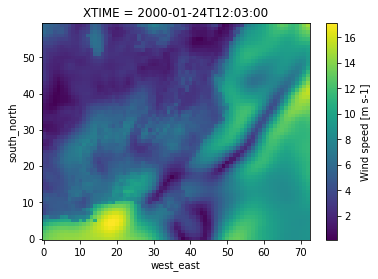

In [57]:
Speed.isel(Time=0).plot()

In [58]:
# Take 1 point only for testing
Wind_dist = Wind_dist.isel(south_north=0,west_east=0)
Speed = Speed.isel(south_north=0,west_east=0)
print(Wind_dist)
print(Speed)

<xarray.DataArray 'Wind distance' (Time: 60)>
array([2354.75086212, 2346.92155838, 2329.91060257, 2318.06373596,
       2308.87882233, 2301.1712265 , 2294.30236816, 2287.91948318,
       2281.82224274, 2275.88945389, 2270.04936218, 2264.2700386 ,
       2258.52607727, 2252.80220032, 2247.08192825, 2241.3633728 ,
       2235.67932129, 2229.98308182, 2224.29199219, 2218.61188889,
       2212.91822433, 2207.22438812, 2201.53123856, 2195.84014892,
       2190.1468277 , 2184.4600296 , 2178.78061295, 2173.1029129 ,
       2167.4174881 , 2161.72485352, 2156.05007172, 2150.36275864,
       2144.6654892 , 2138.9915657 , 2133.31214905, 2127.63444901,
       2121.96619034, 2116.2840271 , 2110.60186386, 2104.92227554,
       2099.24388885, 2093.56807709, 2087.90084839, 2082.2353363 ,
       2076.56209946, 2070.89143753, 2065.22111893, 2059.54462051,
       2053.87722015, 2048.21771622, 2042.55477905, 2036.88755035,
       2031.22976303, 2025.5582428 , 2019.89564896, 2014.24129486,
       2008.5826

In [59]:
print(Speed)
print(UV10MAX5)

<xarray.DataArray 'Wind speed' (Time: 60)>
array([13.081949 , 13.038453 , 12.943948 , 12.878132 , 12.827105 ,
       12.784285 , 12.746124 , 12.710664 , 12.67679  , 12.64383  ,
       12.611385 , 12.579278 , 12.547367 , 12.515568 , 12.4837885,
       12.452019 , 12.420441 , 12.388795 , 12.357178 , 12.325622 ,
       12.29399  , 12.262358 , 12.230729 , 12.199112 , 12.167482 ,
       12.135889 , 12.104337 , 12.072794 , 12.041208 , 12.0095825,
       11.978056 , 11.94646  , 11.914808 , 11.883286 , 11.851734 ,
       11.820191 , 11.788701 , 11.7571335, 11.725566 , 11.694013 ,
       11.662466 , 11.630934 , 11.599449 , 11.567974 , 11.536456 ,
       11.504952 , 11.473451 , 11.441915 , 11.410429 , 11.378987 ,
       11.347527 , 11.316042 , 11.28461  , 11.253101 , 11.2216425,
       11.190229 , 11.1587925, 11.127392 , 11.095967 , 11.06456  ],
      dtype=float32)
Coordinates:
    XLAT     (Time) float32 28.17 28.17 28.17 28.17 ... 28.17 28.17 28.17 28.17
    XLONG    (Time) float32 -93.65 -93

In [40]:
(Wind_dist[1]+Wind_dist[2]*2./3.)/(5.*60.)

<xarray.DataArray 'Wind distance' ()>
array(13.06455078)
Coordinates:
    XLAT     float32 28.17
    XLONG    float32 -93.65

## Calculate the average windows and weights for each window

In [60]:
# Number of time steps in in each windowd, float
ntstep_in_window = Window_ave/timestep
ntstep_in_window

Float64Index([1.6666666666666667, 3.3333333333333335, 6.666666666666667, 10.0,
              20.0],
             dtype='float64')

In [61]:
# Define rolling windows that contain enough timesteps to calculate each average in number of timesteps
rolling_windows = list(map(np.ceil,ntstep_in_window))
rolling_windows

[2.0, 4.0, 7.0, 10.0, 20.0]

For each window, define a scaling factor to apply to each time step for the weighting average.

For example, if ntstep_in_window = 1.6666, we need to average 2 timesteps with the weights (1, 0.66666)

In [62]:
# If ntstep_in_window has no decimal part, the number of weights is the integer part of ntstep_in_window and
# all weights are 1.
# If ntstep_in_window has a decimal part, we need one more weight compared to the previous case. This weight
# is equal to the decimal part.
weights=[]
for ww in ntstep_in_window:
    int_part = np.floor(ww).astype(np.int_)
    last_weight = ww - int_part
    nweights = int_part + (last_weight > 0)
    # All weights are 1 but the last
    window_weights=[1] * int_part
    window_weights.append(last_weight)
    # Remove the last weight if there is no decimal part
    window_weights = window_weights[:nweights]
    # Convert to DataArray
    window_weights = xr.DataArray(window_weights,dims="window")
    weights.append(window_weights)
weights

[<xarray.DataArray (window: 2)>
 array([1.        , 0.66666667])
 Dimensions without coordinates: window,
 <xarray.DataArray (window: 4)>
 array([1.        , 1.        , 1.        , 0.33333333])
 Dimensions without coordinates: window,
 <xarray.DataArray (window: 7)>
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.66666667])
 Dimensions without coordinates: window,
 <xarray.DataArray (window: 10)>
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
 Dimensions without coordinates: window,
 <xarray.DataArray (window: 20)>
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
 Dimensions without coordinates: window]

## Get the frequency of the wrfdly outputs

## Test on the first window
1. Construct the windows for the distance
2. Add the weights and calculate the sum over each window
3. For each hour, get the max. value and the time of the max.

In [63]:
# Construct the windows
Wind_dist_window=Wind_dist.rolling(Time=2).construct(window_dim="window")
# First window starts with NaN
Wind_dist_window=Wind_dist_window[1:]
Wind_dist_window

<xarray.DataArray 'Wind distance' (Time: 59, window: 2)>
array([[2354.75086212, 2346.92155838],
       [2346.92155838, 2329.91060257],
       [2329.91060257, 2318.06373596],
       [2318.06373596, 2308.87882233],
       [2308.87882233, 2301.1712265 ],
       [2301.1712265 , 2294.30236816],
       [2294.30236816, 2287.91948318],
       [2287.91948318, 2281.82224274],
       [2281.82224274, 2275.88945389],
       [2275.88945389, 2270.04936218],
       [2270.04936218, 2264.2700386 ],
       [2264.2700386 , 2258.52607727],
       [2258.52607727, 2252.80220032],
       [2252.80220032, 2247.08192825],
       [2247.08192825, 2241.3633728 ],
       [2241.3633728 , 2235.67932129],
       [2235.67932129, 2229.98308182],
       [2229.98308182, 2224.29199219],
       [2224.29199219, 2218.61188889],
       [2218.61188889, 2212.91822433],
...
       [2104.92227554, 2099.24388885],
       [2099.24388885, 2093.56807709],
       [2093.56807709, 2087.90084839],
       [2087.90084839, 2082.2353363 ],
       [2082.2353363 , 2076.56209946],
       [2076.56209946, 2070.89143753],
       [2070.89143753, 2065.22111893],
       [2065.22111893, 2059.54462051],
       [2059.54462051, 2053.87722015],
       [2053.87722015, 2048.21771622],
       [2048.21771622, 2042.55477905],
       [2042.55477905, 2036.88755035],
       [2036.88755035, 2031.22976303],
       [2031.22976303, 2025.5582428 ],
       [2025.5582428 , 2019.89564896],
       [2019.89564896, 2014.24129486],
       [2014.24129486, 2008.58264923],
       [2008.58264923, 2002.93052673],
       [2002.93052673, 1997.2741127 ],
       [1997.2741127 , 1991.62078857]])
Coordinates:
    XLAT     (Time) float32 28.17 28.17 28.17 28.17 ... 28.17 28.17 28.17 28.17
    XLONG    (Time) float32 -93.65 -93.65 -93.65 -93.65 ... -93.65 -93.65 -93.65
    XTIME    (Time) datetime64[ns] 2000-01-24T12:06:00 ... 2000-01-24T15:00:00
Dimensions without coordinates: Time, window
Attributes:
    units:        m
    description:  Distance travelled by wind

In [64]:
def label_of_max(val_array):
    XTIME=val_array.XTIME
    max_val = val_array.max(dim="Time")
    return XTIME.where(val_array == max_val,drop=True)

In [65]:
Wind_window_weighted=Wind_dist_window.weighted(weights[0]).sum(dim="window")#/Window_ave[0].seconds
wind_window_max = Wind_window_weighted.groupby("XTIME.hour").max(dim="Time")
time_window_max = Wind_window_weighted.groupby("XTIME.hour").apply(label_of_max)

In [66]:
print(wind_window_max)
print(time_window_max)

<xarray.DataArray 'Wind distance' (hour: 4)>
array([3919.36523437, 3703.36658478, 3513.88338089, 3325.02130508])
Coordinates:
  * hour     (hour) int64 12 13 14 15
<xarray.DataArray 'XTIME' (Time: 4)>
array(['2000-01-24T12:06:00.000000000', '2000-01-24T13:00:00.000000000',
       '2000-01-24T14:00:00.000000000', '2000-01-24T15:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    XLAT     (Time) float32 28.17 28.17 28.17 28.17
    XLONG    (Time) float32 -93.65 -93.65 -93.65 -93.65
    XTIME    (Time) datetime64[ns] 2000-01-24T12:06:00 ... 2000-01-24T15:00:00
Dimensions without coordinates: Time


In [67]:
print(dly_d01.TUV10MAX5.sel(south_north=0,west_east=0))
print(dly_d01.TUV10MAX5.Time)

<xarray.DataArray 'TUV10MAX5' (Time: 10)>
array([0., 5., 5., 5., 2., 2., 2., 2., 2., 2.], dtype=float32)
Coordinates:
    XTIME    (Time) datetime64[ns] 2000-01-24T12:00:00 ... 2000-01-24T15:00:00
Dimensions without coordinates: Time
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TIME OF MAXIMUM 5 MIN. WIND SPEED
    units:        minute
    stagger:      
    coordinates:  XLONG XLAT XTIME
<xarray.DataArray 'Time' (Time: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
    XTIME    (Time) datetime64[ns] 2000-01-24T12:00:00 ... 2000-01-24T15:00:00
Dimensions without coordinates: Time


In [68]:
Wind_dist_window.XTIME

<xarray.DataArray 'XTIME' (Time: 59)>
array(['2000-01-24T12:06:00.000000000', '2000-01-24T12:09:00.000000000',
       '2000-01-24T12:12:00.000000000', '2000-01-24T12:15:00.000000000',
       '2000-01-24T12:18:00.000000000', '2000-01-24T12:21:00.000000000',
       '2000-01-24T12:24:00.000000000', '2000-01-24T12:27:00.000000000',
       '2000-01-24T12:30:00.000000000', '2000-01-24T12:33:00.000000000',
       '2000-01-24T12:36:00.000000000', '2000-01-24T12:39:00.000000000',
       '2000-01-24T12:42:00.000000000', '2000-01-24T12:45:00.000000000',
       '2000-01-24T12:48:00.000000000', '2000-01-24T12:51:00.000000000',
       '2000-01-24T12:54:00.000000000', '2000-01-24T12:57:00.000000000',
       '2000-01-24T13:00:00.000000000', '2000-01-24T13:03:00.000000000',
       '2000-01-24T13:06:00.000000000', '2000-01-24T13:09:00.000000000',
       '2000-01-24T13:12:00.000000000', '2000-01-24T13:15:00.000000000',
       '2000-01-24T13:18:00.000000000', '2000-01-24T13:21:00.000000000',
       '2000-01-24T13:24:00.000000000', '2000-01-24T13:27:00.000000000',
       '2000-01-24T13:30:00.000000000', '2000-01-24T13:33:00.000000000',
       '2000-01-24T13:36:00.000000000', '2000-01-24T13:39:00.000000000',
       '2000-01-24T13:42:00.000000000', '2000-01-24T13:45:00.000000000',
       '2000-01-24T13:48:00.000000000', '2000-01-24T13:51:00.000000000',
       '2000-01-24T13:54:00.000000000', '2000-01-24T13:57:00.000000000',
       '2000-01-24T14:00:00.000000000', '2000-01-24T14:03:00.000000000',
       '2000-01-24T14:06:00.000000000', '2000-01-24T14:09:00.000000000',
       '2000-01-24T14:12:00.000000000', '2000-01-24T14:15:00.000000000',
       '2000-01-24T14:18:00.000000000', '2000-01-24T14:21:00.000000000',
       '2000-01-24T14:24:00.000000000', '2000-01-24T14:27:00.000000000',
       '2000-01-24T14:30:00.000000000', '2000-01-24T14:33:00.000000000',
       '2000-01-24T14:36:00.000000000', '2000-01-24T14:39:00.000000000',
       '2000-01-24T14:42:00.000000000', '2000-01-24T14:45:00.000000000',
       '2000-01-24T14:48:00.000000000', '2000-01-24T14:51:00.000000000',
       '2000-01-24T14:54:00.000000000', '2000-01-24T14:57:00.000000000',
       '2000-01-24T15:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    XLAT     (Time) float32 28.17 28.17 28.17 28.17 ... 28.17 28.17 28.17 28.17
    XLONG    (Time) float32 -93.65 -93.65 -93.65 -93.65 ... -93.65 -93.65 -93.65
    XTIME    (Time) datetime64[ns] 2000-01-24T12:06:00 ... 2000-01-24T15:00:00
Dimensions without coordinates: Time
Attributes:
    FieldType:    104
    MemoryOrder:  0  
    description:  minutes since 2000-01-24 12:00:00
    stagger:

In [69]:
Wind_window_weighted.where(Wind_window_weighted["XTIME"].dt.hour == 13)

<xarray.DataArray 'Wind distance' (Time: 59)>
array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan, 3703.36658478, 3693.89070511,
       3684.40114975, 3674.91188049, 3665.42467117, 3655.93803406,
       3646.4535141 , 3636.98043823, 3627.51588821, 3618.04790497,
       3608.56739044, 3599.09156799, 3589.62524414, 3580.13975143,
       3570.65986633, 3561.19966507, 3551.73511505, 3542.2785759 ,
       3532.8222084 , 3523.35193634,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan])
Coordinates:
    XLAT     (Time) float32 28.17 28.17 28.17 28.17 ... 28.17 28.17 28.17 28.17
    XLONG    (Time) float32 -93.65 -93.65 -93.65 -93.65 ... -93.65 -93.65 -93.65
    XTIME    (Time) datetime64[ns] 2000-01-24T12:06:00 ... 2000-01-24T15:00:00
Dimensions without coordinates: Time

In [70]:
wind_window_max
#wind_window_max.sel(hour=12).plot()

<xarray.DataArray 'Wind distance' (hour: 4)>
array([3919.36523437, 3703.36658478, 3513.88338089, 3325.02130508])
Coordinates:
  * hour     (hour) int64 12 13 14 15

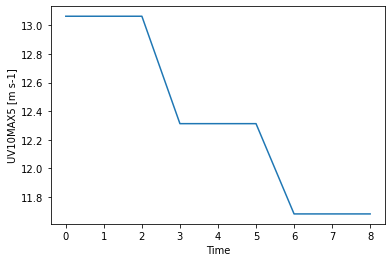

In [52]:
dly_d01["UV10MAX5"].isel(south_north=0,west_east=0,Time=slice(1,None)).plot()

In [53]:
2484.46128845+2354.74279404*0.66666667

4054.2898256591425

In [54]:
2354.74279404*0.66666667

1569.8285372091425

# Draft

In [ ]:
UV10MAX5 = dly_d01["UV10MAX5"]
UV10MAX5.plot(col="Time",col_wrap=4)

In [ ]:
type(a.item())

In [ ]:
print(a)

In [ ]:
b=dly_d01["Times"][0]
b.item()

In [ ]:
a.item().decode()

In [ ]:
Times=
Times

In [121]:
!ncdump -v TUV10MAX5 wrfdly_test/wrfdly_d01_2000-01-24_12:00:00

netcdf wrfdly_d01_2000-01-24_12\:00\:00 {
dimensions:
	Time = UNLIMITED ; // (13 currently)
	DateStrLen = 19 ;
	west_east = 73 ;
	south_north = 60 ;
variables:
	char Times(Time, DateStrLen) ;
	float SUNSHINE(Time, south_north, west_east) ;
		SUNSHINE:FieldType = 104 ;
		SUNSHINE:MemoryOrder = "XY " ;
		SUNSHINE:description = "SUNSHINE LENGTH" ;
		SUNSHINE:units = "second" ;
		SUNSHINE:stagger = "" ;
		SUNSHINE:coordinates = "XLONG XLAT XTIME" ;
	float TSUNSHINE(Time, south_north, west_east) ;
		TSUNSHINE:FieldType = 104 ;
		TSUNSHINE:MemoryOrder = "XY " ;
		TSUNSHINE:description = "TIME OF SUNSHINE" ;
		TSUNSHINE:units = "minute" ;
		TSUNSHINE:stagger = "" ;
		TSUNSHINE:coordinates = "XLONG XLAT XTIME" ;
	float PRMAX5(Time, south_north, west_east) ;
		PRMAX5:FieldType = 104 ;
		PRMAX5:MemoryOrder = "XY " ;
		PRMAX5:description = "MAXIMUM 5 MIN. PRECIPITATION RATE" ;
		PRMAX5:units = "kg m-2 s-1" ;
		PRMAX5:stagger = "" ;
		PRMAX5:coordinates = "XLONG XLAT XTIME" ;
	float TPRMAX5(Time, 

    8.000001, 17, 44, 44, 38, 44, 59, 59, 17, 41, 50, 59, 59, 47, 59, 59, 59, 
    59, 59, 59, 59, 59, 35, 41, 47, 50, 53, 59, 56, 23, 2, 2, 2, 2, 2, 2, 2, 
    2, 2, 2, 2, 2, 2, 29, 53, 35, 38, 26, 2,
  2, 2, 2, 8.000001, 2, 2, 8.000001, 8.000001, 8.000001, 8.000001, 2, 2, 2, 
    2, 8.000001, 8.000001, 8.000001, 8.000001, 8.000001, 14, 11, 8.000001, 
    8.000001, 8.000001, 8.000001, 23, 44, 38, 38, 50, 59, 59, 2, 11, 47, 59, 
    50, 47, 59, 59, 59, 59, 59, 59, 59, 59, 59, 56, 59, 59, 59, 56, 47, 47, 
    26, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 35, 47, 35, 32, 14, 2,
  2, 2, 2, 8.000001, 2, 8.000001, 8.000001, 8.000001, 8.000001, 8.000001, 
    8.000001, 8.000001, 2, 8.000001, 8.000001, 8.000001, 8.000001, 8.000001, 
    8.000001, 11, 8.000001, 8.000001, 8.000001, 8.000001, 14, 38, 44, 20, 41, 
    59, 59, 59, 59, 2, 17, 59, 2, 29, 59, 59, 59, 38, 59, 59, 59, 59, 59, 59, 
    59, 44, 23, 59, 53, 59, 59, 38, 23, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 32, 44, 
    35, 2, 2, 53,
  2, 8.000001, 

  2, 2, 2, 2, 32, 35, 59, 59, 59, 59, 59, 59, 59, 53, 59, 59, 59, 59, 35, 44, 
    47, 59, 59, 59, 59, 26, 23, 2, 59, 59, 59, 32, 26, 20, 23, 20, 2, 2, 2, 
    2, 2, 2, 2, 2, 2, 2, 2, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 
    59, 59, 59, 59, 59, 59, 59, 59, 32, 20, 59, 59, 59, 59,
  2, 2, 2, 2, 17, 32, 32, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 
    59, 59, 59, 59, 59, 32, 26, 2, 2, 2, 59, 59, 59, 26, 29, 20, 2, 2, 2, 2, 
    2, 2, 2, 2, 2, 2, 2, 2, 2, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 
    59, 59, 59, 59, 59, 59, 59, 59, 41, 2, 38, 47, 59,
  2, 2, 2, 2, 2, 32, 32, 20, 20, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 
    59, 59, 59, 59, 59, 32, 23, 2, 2, 2, 2, 2, 29, 2, 29, 26, 2, 2, 2, 2, 2, 
    2, 2, 2, 2, 2, 2, 2, 2, 2, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 2, 2, 
    2, 59, 59, 59, 59, 59, 59, 2, 2, 38, 59,
  2, 2, 2, 2, 2, 2, 2, 2, 5, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 
    59, 59, 59, 32, 26, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [122]:
list(range(5,60,3))

[5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59]